In [9]:
from msdm.domains import GridWorld
from msdm.algorithms.entregpolicyiteration import entropy_regularized_policy_iteration
from msdm.core.problemclasses.mdp import TabularPolicy
from msdm.core.distributions import DictDistribution
import torch
from torch import nn
import numpy as np
from frozendict import frozendict
from dataset import TrajectoryDataset, FeaturesDataset
from algorithms import MaxLikelihoodIRL, ImitationLearning
import matplotlib.pyplot as plt

In [10]:
# hyperparameters
num_trajs = 10000
epochs = 50
batch_size = 128
lr = 1
weight_decay = 0
momentum = 0.9
entropy_weight = 2
discount_rate = 0.99
step_cost = -1

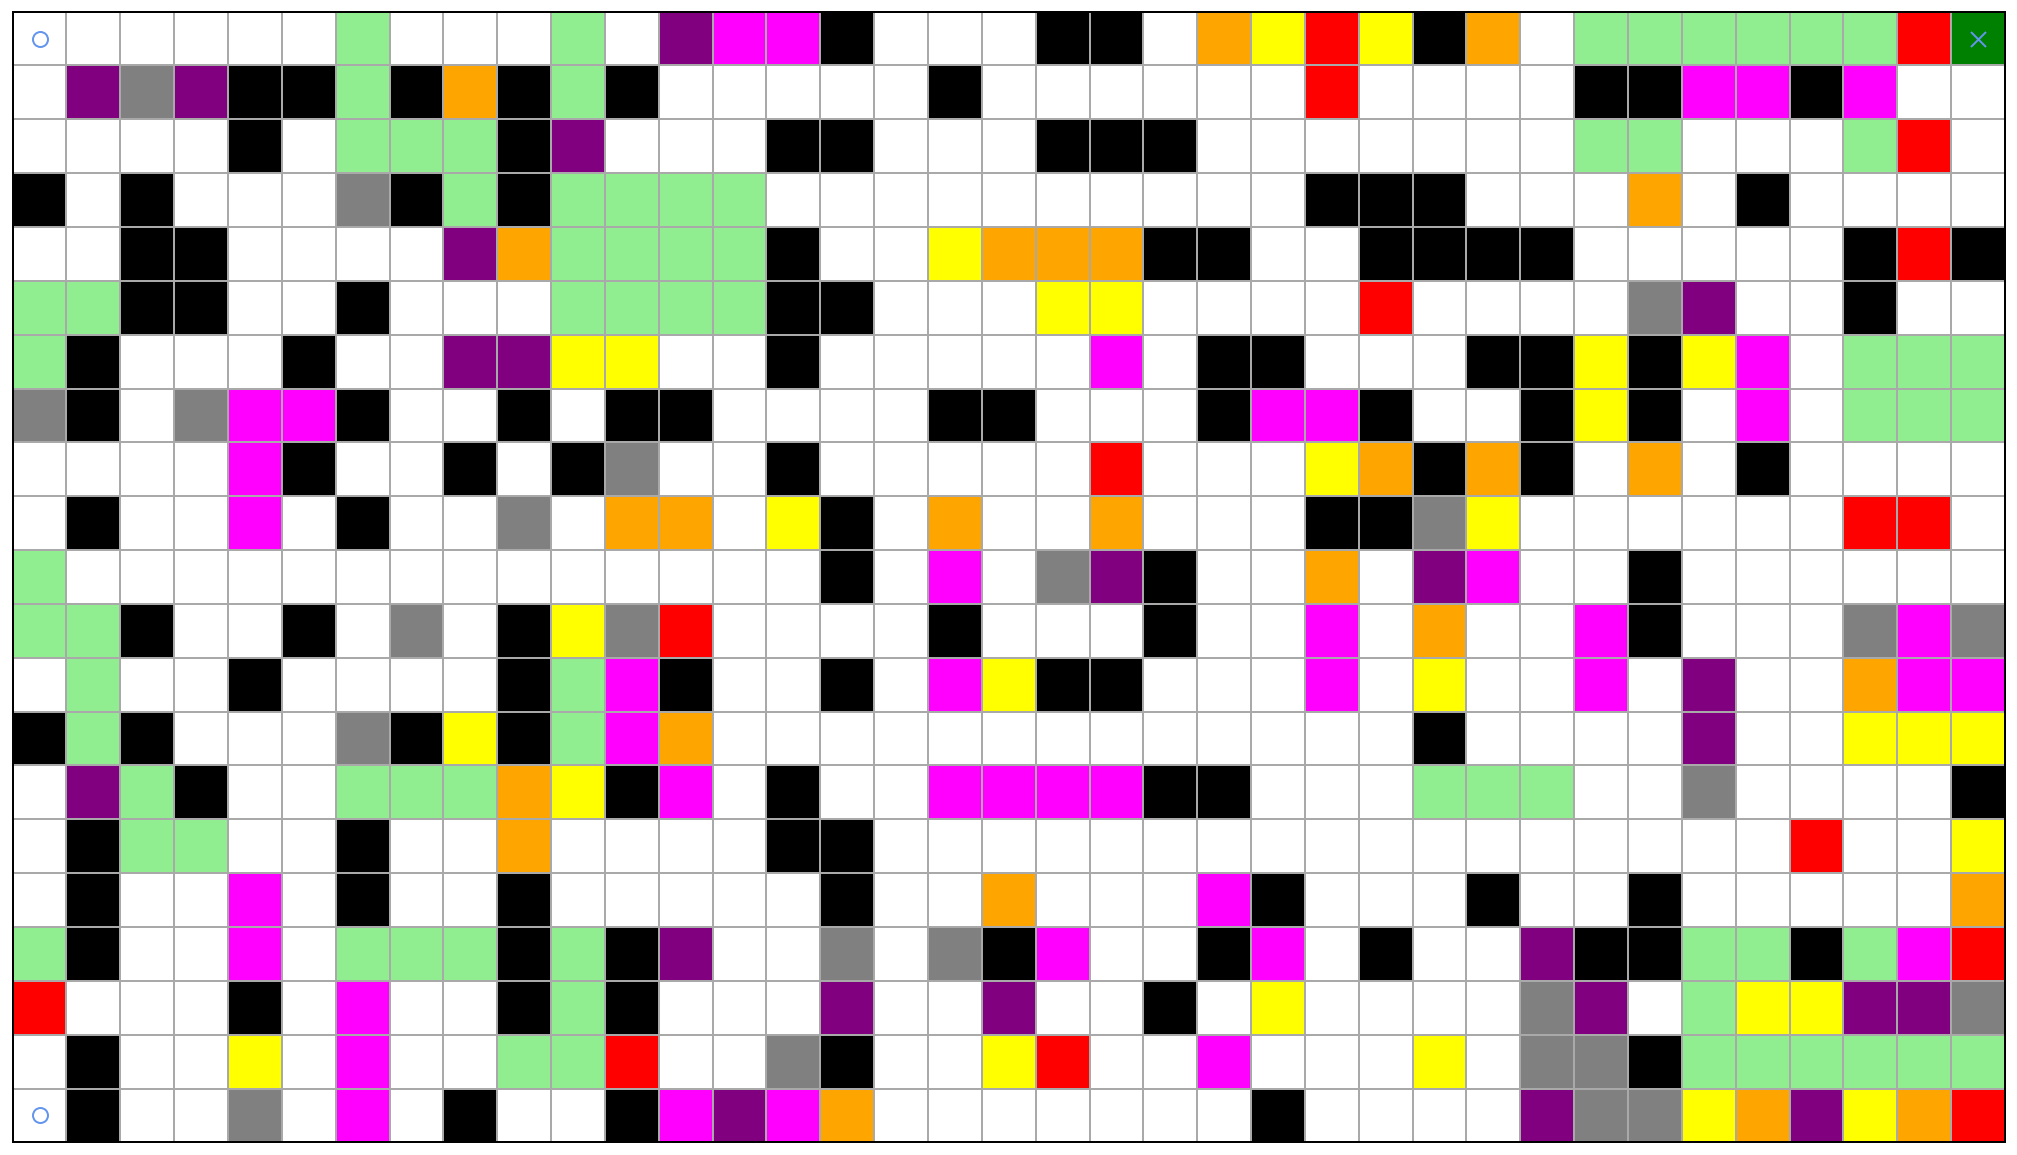

In [11]:
# Gridworld with 8 FEATURES not including goal and '.' states
mdp = GridWorld(
    tile_array=[
        "s.....r...r.uvvx...xx.ywzwxy.rrrrrrzg",
        ".utuxxrxyxrx.....x......z....xxvvxv..",
        "....x.rrrxu...xx...xxx.......rr...rz.",
        "x.x...txrxrrrr..........xxx...y.x....",
        "..xx....uyrrrrx..wyyyxx..xxxx.....xzx",
        "rrxx..x...rrrrxx...ww....z....tu..x..",
        "rx...x..uuww..x.....v.xx...xxwxwv.rrr",
        "tx.tvvx..x.xx....xx...xvvx..xwx.v.rrr",
        "....vx..x.xt..x.....z...wyxyx.y.x....",
        ".x..v.x..t.yy.wx.y..y...xxtw......zz.",
        "r..............x.v.tux..y.uv..x......",
        "rrx..x.t.xwtz....x...x..v.y..vx...tvt",
        ".r..x....xrvx..x.vwxx...v.w..v.u..yvv",
        "xrx...txwxrvy.............x....u..www",
        ".urx..rrrywxv.x..vvvvxx...rrr..t....x",
        ".xrr..x..y....xx.................z..w",
        ".x..v.x..x.....x..y...vx...x..x.....y",
        "rx..v.rrrxrxu..t.txv..xv.x..uxxrrxrvz",
        "z...x.v..xrx...u..u..x.w....tu.rwwuut",
        ".x..w.v..rrz..tx..wz..v...w.ttxrrrrrr",
        "sx..t.v.x..xvuvy.......x....uttwyuwyz",
    ],
    feature_rewards={
        '.': 0,
        'g': 0,
        'r': 0.5,
        't': -1,
        'u': -2,
        'v': -5,
        'w': -7,
        'x': -10,
        'y': -13,
        'z': -20,
    },
    absorbing_features=('g'),
    initial_features=('s'),
    discount_rate=discount_rate,
    step_cost=step_cost,
)
featurecolors = {
    '.': 'white',
    'g': 'green',
    'r': 'lightgreen',
    't': 'grey',
    'u': 'purple',
    'v': 'magenta',
    'w': 'yellow',
    'x': 'black',
    'y': 'orange',
    'z': 'red',
}
mdp.plot(featurecolors=featurecolors)


In [12]:
# Use the Maximum Entropy IRL policy to generate trajectories
expert_erpi_params = dict(
    transition_matrix=torch.tensor(mdp.transition_matrix),
    reward_matrix=torch.tensor(mdp.reward_matrix),
    discount_rate=torch.tensor(mdp.discount_rate),
    # the lower this is, the more optimal the policy
    entropy_weight=torch.tensor([entropy_weight]),
    n_planning_iters=10,
    policy_prior=None,
    initial_policy=None,
    check_convergence=True,
    force_nonzero_probabilities=True,
)

# Max Entropy IRL expert policy
expert_erpi = entropy_regularized_policy_iteration(
    **expert_erpi_params
)

expert_policy = TabularPolicy.from_matrix(
    states=mdp.state_list,
    actions=mdp.action_list,
    policy_matrix=expert_erpi.policy.detach().numpy()
)


In [13]:
# Convert our numpy 2d array to a tensor for training
# do I need to convert the labels to a tensor? yes, does it for us in Lambda (target_transform)
class ToTensor(object):
  """Convert ndarrays in sample to Tensors."""

  def __call__(self, sample):
    return torch.from_numpy(sample)

In [14]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


class ActionClassifier(nn.Module):
  def __init__(self):
    super(ActionClassifier, self).__init__()
    self.conv1 = nn.Sequential(
        nn.Conv1d(1, 16, 3, padding=1),
        nn.BatchNorm1d(16),
        nn.ReLU()
    )
    self.conv2 = nn.Sequential(
        nn.Conv1d(16, 32, 3, padding=1),
        nn.BatchNorm1d(32),
        nn.ReLU()
    )
    self.conv3 = nn.Sequential(
        nn.Conv1d(32, 64, 3, stride=2, padding=1),
        nn.BatchNorm1d(64),
        nn.ReLU()
    )
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 5),
    )
    # don't use softmax bc nn.CrossEntropyLoss takes unnormalized outputs
    # self.softmax = nn.Softmax(dim=1)

  def forward(self, x):
    x_conv1 = self.conv1(x)
    x_conv2 = self.conv2(x_conv1)
    x_conv3 = self.conv3(x_conv2)
    x_flat = self.flatten(x_conv3)
    logits = self.linear_relu_stack(x_flat)
    # probabilities = self.softmax(logits)
    return logits


model = ActionClassifier().to(device)
print(model)

Using cpu device
ActionClassifier(
  (conv1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv3): Sequential(
    (0): Conv1d(32, 64, kernel_size=(3,), stride=(2,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=5, bias=True)
  )
)


In [15]:
# Generate gen_iters of trajectories
gen_iters = num_trajs
trajectories = []

for _ in range(gen_iters):
  # Starts at one of the labelled starting points
  trajectory = expert_policy.run_on(mdp)
  formatted_traj = {}
  formatted_traj['state_traj'] = trajectory.state_traj
  formatted_traj['action_traj'] = trajectory.action_traj
  trajectories.append(formatted_traj)

trajs_dataset = TrajectoryDataset(trajectories)
features_dataset = FeaturesDataset(mdp, trajectories, transform=ToTensor())

In [ ]:
# Use Cross Entropy Loss for classification
loss_fn = nn.CrossEntropyLoss()

# better optimizer with a scheduler to decrease learning rate by 0.1 at indicated steps
optimizer = torch.optim.SGD(
    model.parameters(), lr=0.1, weight_decay=0.0001, momentum=momentum)
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer, [10, 20, 30, 40], gamma=0.1)

In [ ]:
def featurizer(state, action, next_state):
  feature_name = mdp.location_features.get(next_state, 's')
  if feature_name in 's':
    return {}
  return {feature_name: 1}

def fixed_reward(state, action, next_state):
  return mdp.step_cost

In [ ]:
algorithm = MaxLikelihoodIRL(mdp, featurizer, fixed_reward, batch_size=batch_size, epochs=epochs,
                             lr=lr, momentum=momentum, entropy_weight=entropy_weight, weight_decay=weight_decay)

supervised_learning = ImitationLearning(
    mdp, _, _, model, loss_fn, optimizer, scheduler=scheduler, batch_size=batch_size, epochs=epochs)


In [ ]:
learned_weights, the_policy, max_losses = algorithm.learn(trajs_dataset)
optimized_model, imitation_losses = supervised_learning.learn(features_dataset)


Using cpu
Inital reward weights: tensor([-1.4185,  1.2404,  0.2024, -0.2852, -0.7467], dtype=torch.float64)

loss: 2.322097  [    0/10000]
loss: 1.724695  [    0/10000]
loss: 1.632993  [    0/10000]
loss: 1.740636  [    0/10000]
loss: 1.749771  [    0/10000]
loss: 1.866481  [    0/10000]
loss: 1.830929  [    0/10000]
loss: 1.615136  [    0/10000]
loss: 1.879451  [    0/10000]
loss: 1.694390  [    0/10000]
loss: 1.758329  [    0/10000]
loss: 1.750879  [    0/10000]
loss: 1.780777  [    0/10000]
loss: 1.685266  [    0/10000]
loss: 1.668990  [    0/10000]
loss: 1.897092  [    0/10000]
loss: 1.694206  [    0/10000]
loss: 1.749220  [    0/10000]
loss: 1.786807  [    0/10000]
loss: 1.838805  [    0/10000]
loss: 1.663982  [    0/10000]
loss: 1.822361  [    0/10000]
loss: 1.725878  [    0/10000]
loss: 1.609854  [    0/10000]
loss: 1.640273  [    0/10000]
loss: 1.738591  [    0/10000]
loss: 1.726312  [    0/10000]
loss: 1.771751  [    0/10000]
loss: 1.795881  [    0/10000]


In [ ]:
# solve with matrices returned by gridworld object
max_policy = TabularPolicy.from_matrix(
    states=mdp.state_list,
    actions=mdp.action_list,
    policy_matrix=the_policy.policy.detach().numpy()
)

mdp.plot(featurecolors=featurecolors).plot_policy(max_policy)
mdp.plot().plot_state_map(max_policy.evaluate_on(mdp).V)

mdp.plot(featurecolors=featurecolors).plot_policy(expert_policy)
mdp.plot().plot_state_map(expert_policy.evaluate_on(mdp).V)

optimized_model.eval()

temp_imitpolicy = {}
int_to_action = {0: frozendict(dx=0, dy=1), 1: frozendict(
    dx=0, dy=-1), 2: frozendict(dx=1, dy=0), 3: frozendict(dx=-1, dy=0), 4: frozendict(dx=0, dy=0)}

softmax_fn = nn.Softmax(dim=1)

# so pred doesn't have a grad_fn attached to it
with torch.no_grad():
  for s in mdp.state_list:
    state_feature = torch.from_numpy(
        np.array([features_dataset.getStateFeature(s)], dtype='f')).to(device)
    # pred = model(state_feature)[0]
    # pred = supervised_learning.model(state_feature)
    pred = optimized_model(state_feature)
    probs = softmax_fn(pred)[0]
    temp_imitpolicy[s] = {}
    # for each action in each state, grab from the "pred" result the probability of taking this action in this state and add that to the dictionary policy which is a dictionary with states as keys and a dictionary of "action: prob of taking this action in this state" as values
    for a_i, prob in enumerate(probs):
      temp_imitpolicy[s][int_to_action[a_i]] = prob.item()

# to turn policy into an actual policy object that we can call the MSDM functions on
imitation_policy = TabularPolicy({s: DictDistribution(ap) for s, ap in temp_imitpolicy.items()})

mdp.plot(featurecolors=featurecolors).plot_policy(imitation_policy)
mdp.plot().plot_state_map(imitation_policy.evaluate_on(mdp).V)

In [ ]:
print(f"Max policy initial value: {max_policy.evaluate_on(mdp).initial_value}")
print(f"Expert policy initial value: {expert_policy.evaluate_on(mdp).initial_value}")
print(f"Imitation policy initial value: {imitation_policy.evaluate_on(mdp).initial_value}")

In [ ]:
# Create a gridworld
mdp2 = GridWorld(
    tile_array=[
        "tvvtvyyr....z.yruwx.x.uxxxwvy..............rrrx",
        "tzwyu.x..yv.yvw...wrtwxu...wz.yyyw.wwvy..wx..ru",
        "wyrrrrrr..x.ytt.v..wr....x....y.yzztzzygyx..xy.",
        "y.rxwrz..yz..rrrzx.rw.yzvuuwzuwwuv.yxzuzz..zuvr",
        "wxrzxu..tvzwyurtww....yuwyrr.wvx.rtuz.......wvt",
        "..rzrzz....rzzyyxwtxruwxwwzuutzr.zwuruwvzrrytyr",
        "wyrtt.twuz.vrzwvyzyzwwzxzuzxtww...uurxtxyrwrrr.",
        "rtrwzzzz...uuww.zywzrwvzwx.yvvy.w...yzzw..rwtrv",
        "uyrzuzzy.wwvztwrvy.wzyvwwzw..zz..zy.ux...zrry.t",
        "rwrrrrrrrryryyyv.rwu.zuyyuzwwxt.xzt....vyzrrrr.",
        "tw.uryrrsrr.tuxrtzwz........trt.twrvu...tu.xxyv",
        "zy.wrtrrrrr.xxtx.uzt.vxvru.txwx.v.ry..wt.xuvxvr",
        "rt.wr..wury.....yvv...v.zu......vu.xyrrrr.uuwxt",
        "xr.ywzvwruuutzy.x.y..r.zrvztxz.ryvvtyuz.x.xxvtz",
        "rwrrtttywrvrvzy.w.ty.tyyyx.r.r..uw...xxvu.ytxy.",
        "yztrtvz.t.uzyr..wwyr.t.yvz.uyur.zy.z......vvvtu",
        "wuz.uwzvv.vyu.z............rzyx....wx.yyvrzr.x.",
        "utzrrr.utr.yu.wvtvuz.v..vz.rrrrwywvu.rzwtu.z.yv",
        "yvzw...yt.tzur.uuz.yty.rt.vxwtrz.rtw.ryxxtvxrvy",
        "ywy..vrwy.vwxw.w..uru..zrvwutr..zxxz.yxtuvzvyvz",
        "ytzw.y.........xrxuytv.zztuvzvrwzytw.rr..ztzwvt",
        "z..r.wr.trytrrrvrzywuvrr.trtzy..tvvv.tvx.wwrt.y",
        "uwu..yuzuzrwrrr.r.rr.rr...r.rrrrrr...wyt.wvrzuv",
        "yu.......r...vvr.wy..urz.w...v.y.w.zw.ru.vuxtt.",
        ".w..s..x.z.tw.v..zw.y.rt..u.tu.x.t....zr.wx.vu.",
        "vyrrrrv.wy..v.r..v.z.zr.vyz..rrr...s.......xvvx",
        "r...rrr.....rrrt..r..rr...w..w.vr...ry...rr.rwy",
    ],
    feature_rewards={
        '.': 0,
        'g': 0,
        'r': 0.5,
        't': -1,
        'u': -2,
        'v': -5,
        'w': -7,
        'x': -10,
        'y': -13,
        'z': -20,
    },
    absorbing_features=('g'),
    initial_features=('s'),
    discount_rate=discount_rate,
    step_cost=step_cost,
)

mdp2.plot(featurecolors=featurecolors)


In [ ]:
expert_erpi_params2 = dict(
    transition_matrix=torch.tensor(mdp2.transition_matrix),
    reward_matrix=torch.tensor(mdp2.reward_matrix),
    discount_rate=torch.tensor(mdp2.discount_rate),
    # the lower this is, the more optimal the policy
    entropy_weight=torch.tensor([entropy_weight]),
    n_planning_iters=10,
    policy_prior=None,
    initial_policy=None,
    check_convergence=True,
    force_nonzero_probabilities=True,
)

# Max Entropy IRL expert policy
expert_erpi2 = entropy_regularized_policy_iteration(
    **expert_erpi_params2
)

expert_policy2 = TabularPolicy.from_matrix(
    states=mdp2.state_list,
    actions=mdp2.action_list,
    policy_matrix=expert_erpi2.policy.detach().numpy()
)


In [ ]:
def featurizer2(state, action, next_state):
  feature_name = mdp2.location_features.get(next_state, 's')
  if feature_name in 's':
    return {}
  return {feature_name: 1}


def fixed_reward2(state, action, next_state):
  return mdp2.step_cost


In [ ]:
algorithm2 = MaxLikelihoodIRL(mdp2, featurizer2, fixed_reward2, batch_size=batch_size, epochs=epochs, lr=lr, weight_decay=weight_decay, momentum=momentum, entropy_weight=entropy_weight)

# compute policy from learned weights
feature_reward_matrix2 = torch.einsum(
    "sanf,f->san",
    algorithm2.get_feature_matrix(),
    learned_weights
)

reward_matrix2 = feature_reward_matrix2 + algorithm2.get_fixed_reward_matrix()
terminal_index = mdp2.state_index.get(
    frozendict({'x': -1, 'y': -1}))
reward_matrix2[:, :, terminal_index] = 0

my_erpi_params2 = dict(
    transition_matrix=torch.tensor(mdp2.transition_matrix),
    reward_matrix=reward_matrix2,
    discount_rate=torch.tensor(mdp2.discount_rate),
    # the lower this is, the more optimal the policy
    entropy_weight=torch.tensor([entropy_weight]),
    n_planning_iters=10,
    policy_prior=None,
    initial_policy=None,
    check_convergence=True,
    force_nonzero_probabilities=True,
)


In [ ]:
features_dataset2 = FeaturesDataset(mdp2, trajectories, transform=ToTensor())

In [ ]:
optimized_model.eval()

temp_imitpolicy2 = {}
# so pred doesn't have a grad_fn attached to it
with torch.no_grad():
  for s in mdp2.state_list:
    state_feature = torch.from_numpy(
        np.array([features_dataset2.getStateFeature(s)], dtype='f')).to(device)
    # pred = model(state_feature)[0]
    pred = optimized_model(state_feature)
    probs = softmax_fn(pred)[0]
    temp_imitpolicy2[s] = {}
    # for each action in each state, grab from the "pred" result the probability of taking this action in this state and add that to the dictionary policy which is a dictionary with states as keys and a dictionary of "action: prob of taking this action in this state" as values
    for a_i, prob in enumerate(probs):
      temp_imitpolicy2[s][int_to_action[a_i]] = prob.item()

# to turn policy into an actual policy object that we can call the MSDM functions on
imitation_policy2 = TabularPolicy({s: DictDistribution(ap)
                       for s, ap in temp_imitpolicy2.items()})


In [ ]:
# solve with matrices returned by gridworld object
my_erpi2 = entropy_regularized_policy_iteration(
    **my_erpi_params2
)

max_policy2 = TabularPolicy.from_matrix(
    states=mdp2.state_list,
    actions=mdp2.action_list,
    policy_matrix=my_erpi2.policy.detach().numpy()
)

mdp2.plot(featurecolors=featurecolors).plot_policy(max_policy2)
mdp2.plot().plot_state_map(max_policy2.evaluate_on(mdp2).V)

mdp2.plot(featurecolors=featurecolors).plot_policy(expert_policy2)
mdp2.plot().plot_state_map(expert_policy2.evaluate_on(mdp2).V)

mdp2.plot(featurecolors=featurecolors).plot_policy(imitation_policy2)
mdp2.plot().plot_state_map(imitation_policy2.evaluate_on(mdp2).V)


In [ ]:
print(f"Max policy initial value: {max_policy2.evaluate_on(mdp2).initial_value}")
print(f"Expert policy initial value: {expert_policy2.evaluate_on(mdp2).initial_value}")
print(f"Imitation policy initial Value: {imitation_policy2.evaluate_on(mdp2).initial_value}")
